# Hybrid quantum-classical Neural Networks with PyTorch and Qiskit

Machine learning (ML) has established itself as a successful interdisciplinary field which seeks to mathematically extract generalizable information from data. Throwing in quantum computing gives rise to interesting areas of research which seek to leverage the principles of quantum mechanics to augment machine learning or vice-versa. Whether you're aiming to enhance classical ML algorithms by outsourcing difficult calculations to a quantum computer or optimise quantum algorithms using classical ML architectures - both fall under the diverse umbrella of quantum machine learning (QML).

In this chapter, we explore how a classical neural network can be partially quantized to create a hybrid quantum-classical neural network. We will code up a simple example that integrates **Qiskit** with a state-of-the-art open-source software package - **[PyTorch](https://pytorch.org/)**. The purpose of this example is to demonstrate the ease of integrating Qiskit with existing ML tools and to encourage ML practitioners to explore what is possible with quantum computing.

## Contents

1. [How Does it Work?](#how)    
    1.1 [Preliminaries](#prelims)    
2. [So How Does Quantum Enter the Picture?](#quantumlayer)
3. [Let's code!](#code)  
    3.1 [Imports](#imports)   
    3.2 [Create a "Quantum Class" with Qiskit](#q-class)    
    3.3 [Create a "Quantum-Classical Class" with PyTorch](#qc-class)    
    3.4 [Data Loading and Preprocessing](#data-loading-preprocessing)    
    3.5 [Creating the Hybrid Neural Network](#hybrid-nn)     
    3.6 [Training the Network](#training)    
    3.7 [Testing the Network](#testing)
4. [What Now?](#what-now)

## 1. How does it work? <a id='how'></a>
<img src="hybridnetwork.png" width="800"/>

**Fig.1** Illustrates the framework we will construct in this chapter. Ultimately, we will create a hybrid quantum-classical neural network that seeks to classify hand drawn digits. Note that the edges shown in this image are all directed downward; however, the directionality is not visually indicated. 

### 1.1 Preliminaries <a id='prelims'></a>
The background presented here on classical neural networks is included to establish relevant ideas and shared terminology; however, it is still extremely high-level. __If you'd like to dive one step deeper into classical neural networks, see the well made video series by youtuber__ [3Blue1Brown](https://youtu.be/aircAruvnKk). Alternatively, if you are already familiar with classical networks, you can [skip to the next section](#quantumlayer).

###### Neurons and Weights
A neural network is ultimately just an elaborate function that is built by composing smaller building blocks called neurons. A ***neuron*** is typically a simple, easy-to-compute, and nonlinear function that maps one or more inputs to a single real number. The single output of a neuron is typically copied and fed as input into other neurons. Graphically, we represent neurons as nodes in a graph and we draw directed edges between nodes to indicate how the output of one neuron will be used as input to other neurons. It's also important to note that each edge in our graph is often associated with a scalar-value called a [***weight***](https://en.wikipedia.org/wiki/Artificial_neural_network#Connections_and_weights). The idea here is that each of the inputs to a neuron will be multiplied by a different scalar before being collected and processed into a single value. The objective when training a neural network consists primarily of choosing our weights such that the network behaves in a particular way. 

###### Feed Forward Neural Networks
It is also worth noting that the particular type of neural network we will concern ourselves with is called a **[feed-forward neural network (FFNN)](https://en.wikipedia.org/wiki/Feedforward_neural_network)**. This means that as data flows through our neural network, it will never return to a neuron it has already visited. Equivalently, you could say that the graph which describes our neural network is a **[directed acyclic graph (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph)**. Furthermore, we will stipulate that neurons within the same layer of our neural network will not have edges between them. 

###### IO Structure of Layers
The input to a neural network is a classical (real-valued) vector. Each component of the input vector is multiplied by a different weight and fed into a layer of neurons according to the graph structure of the network. After each neuron in the layer has been evaluated, the results are collected into a new vector where the i'th component records the output of the i'th neuron. This new vector can then treated as input for a new layer, and so on. We will use the standard term ***hidden layer*** to describe all but the first and last layers of our network.


## 2. So How Does Quantum Enter the Picture? <a id='quantumlayer'> </a>

To create a quantum-classical neural network, one can implement a hidden layer for our neural network using a parameterized quantum circuit. By "parameterized quantum circuit", we mean a quantum circuit where the rotation angles for each gate are specified by the components of a classical input vector. The outputs from our neural network's previous layer will be collected and used as the inputs for our parameterized circuit. The measurement statistics of our quantum circuit can then be collected and used as inputs for the following layer. A simple example is depicted below:

<img src="neuralnetworkQC.png" width="800"/>

Here, $\sigma$ is a [nonlinear function](https://en.wikipedia.org/wiki/Activation_function) and $h_i$ is the value of neuron $i$ at each hidden layer. $R(h_i)$ represents any rotation gate about an angle equal to $h_i$ and $y$ is the final prediction value generated from the hybrid network.  

### What about backpropagation?
If you're familiar with classical ML, you may immediately be wondering *how do we calculate gradients when quantum circuits are involved?* This would be necessary to enlist powerful optimisation techniques such as **[gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)**. It gets a bit technical, but in short, we can view a quantum circuit as a black box and the gradient of this black box with respect to its parameters can be calculated as follows: 

<img src="quantumgradient.png" width="800"/>

where $\theta$ represents the parameters of the quantum circuit and $s$ is a macroscopic shift. The gradient is then simply the difference between our quantum circuit evaluated at $\theta+s$ and $\theta - s$. Thus, we can systematically differentiate our quantum circuit as part of a larger backpropogation routine. This closed form rule for calculating the gradient of quantum circuit parameters is known as **[the parameter shift rule](https://arxiv.org/pdf/1905.13311.pdf)**. 

## 3. Let's code! <a id='code'></a>


### 3.1 Imports <a id='imports'></a>
First, we import some handy packages that we will need, including Qiskit and PyTorch.

In [1]:
!python --version

Python 3.7.6


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

from tqdm import tqdm

NUM_SHOTS = 10000
SHIFT = np.pi/4

### 3.4 Data Loading and Preprocessing <a id='data-loading-preprocessing'></a>
##### Putting this all together:
We will create a simple hybrid neural network to classify images of two types of digits (0 or 1) from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). We first load MNIST and filter for pictures containing 0's and 1's. These will serve as inputs for our neural network to classify.

#### Training data

In [21]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.append(np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples]),np.where(X_train.targets == 2)[0][:n_samples]),np.where(X_train.targets == 3)[0][:n_samples])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

print(X_train.targets)

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

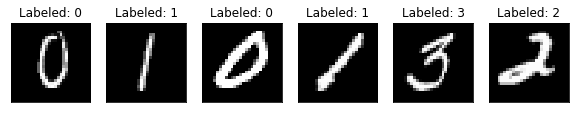

In [22]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

#### Testing data

In [20]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

print(X_test.targets)

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])


### 3.2 Create a "Quantum Class" with Qiskit <a id='q-class'></a>
We can conveniently put our Qiskit quantum functions into a class. First, we specify how many trainable quantum parameters and how many shots we wish to use in our quantum circuit. In this example, we will keep it simple and use a 1-qubit circuit with one trainable quantum parameter $\theta$. We hard code the circuit for simplicity and use a $RY-$rotation by the angle $\theta$ to train the output of our circuit. The circuit looks like this:

<img src="1qubitcirc.png" width="400"/>

In order to measure the output in the $z-$basis, we calculate the $\sigma_\mathbf{z}$ expectation. 
$$\sigma_\mathbf{z} = \sum_i z_i p(z_i)$$
We will see later how this all ties into the hybrid neural network.

In [43]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        self.phi = qiskit.circuit.Parameter('phi')
        self.lam = qiskit.circuit.Parameter('lambda')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.u3(self.theta, self.phi, self.lam, all_qubits)
        self._circuit.barrier()
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, params):
        #print(params)
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta : params[0], 
                                                 self.phi : params[1], 
                                                 self.lam : params[2]}])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Let's test the implementation

In [44]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, NUM_SHOTS)
print('Expected value for rotation [pi/4, pi/4, pi/4]: {}'.format(circuit.run([np.pi/4, np.pi/4, np.pi/4])[0]))
circuit._circuit.draw()

Expected value for rotation [pi/4, pi/4, pi/4]: 0.7491


┌───┐ ░ ┌──────────────────────┐ ░  ░ ┌─┐
   q_0: ┤ H ├─░─┤ U3(theta,phi,lambda) ├─░──░─┤M├
        └───┘ ░ └──────────────────────┘ ░  ░ └╥┘
meas_0: ═══════════════════════════════════════╩═

### 3.3 Create a "Quantum-Classical Class" with PyTorch <a id='qc-class'></a>
Now that our quantum circuit is defined, we can create the functions needed for backpropagation using PyTorch. [The forward and backward passes](http://www.ai.mit.edu/courses/6.034b/backprops.pdf) contain elements from our Qiskit class. The backward pass directly computes the analytical gradients using the finite difference formula we introduced above.

In [35]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result

    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        gradients = []
        
        for i in range(len(input_list)):
            params = input_list[i]
            gradient = []
            
            for k in range(len(params)):
                shift_right = params
                shift_right[k] = params[k] + ctx.shift
                shift_left = params
                shift_left[k] = params[k] - ctx.shift

                expectation_right = ctx.quantum_circuit.run(shift_right)
                expectation_left  = ctx.quantum_circuit.run(shift_left)

                gradient.append(torch.tensor([expectation_right]) - torch.tensor([expectation_left]))
                
            gradients.append(gradient)

        gradients = np.array(gradients)
        
        return torch.tensor([gradients]).float() * grad_output.float(), None, None
    
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, n_qubits, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [37]:
quantum_circ = Hybrid(2, qiskit.Aer.get_backend('qasm_simulator'), NUM_SHOTS, SHIFT)
quantum_circ.quantum_circuit._circuit.draw()

┌───┐ ░ ┌──────────────────────┐ ░  ░ ┌─┐   
   q_0: ┤ H ├─░─┤ U3(theta,phi,lambda) ├─░──░─┤M├───
        ├───┤ ░ ├──────────────────────┤ ░  ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ U3(theta,phi,lambda) ├─░──░──╫─┤M├
        └───┘ ░ └──────────────────────┘ ░  ░  ║ └╥┘
meas_0: ═══════════════════════════════════════╩══╬═
                                                  ║ 
meas_1: ══════════════════════════════════════════╩═

In [38]:
x = torch.tensor([[np.pi/4, np.pi/4, np.pi/4]], requires_grad=True)
# x = torch.tensor([[0.0, 0.0, 0.0]], requires_grad=True)

qc = HybridFunction.apply
y1 = qc(x, circuit, np.pi/2)
y1.backward()
print(x.grad)

[[0.78539819 0.78539819 0.78539819]]
tensor([[0.0019, 0.0029, 0.0006]])


  0%|          | 0/100 [00:00<?, ?it/s]

[[0.78539819 0.78539819 0.78539819]]


  1%|          | 1/100 [00:00<00:57,  1.72it/s]

[[0.88539791 0.6853984  0.88539815]]


  2%|▏         | 2/100 [00:01<00:55,  1.75it/s]

[[0.89022648 0.73795164 0.96469045]]


  3%|▎         | 3/100 [00:01<00:54,  1.78it/s]

[[0.95373935 0.81088614 0.97238404]]


  4%|▍         | 4/100 [00:02<00:52,  1.82it/s]

[[1.03166497 0.83185124 1.0245924 ]]


  5%|▌         | 5/100 [00:02<00:51,  1.84it/s]

[[1.06093347 0.82330751 1.05354691]]


  6%|▌         | 6/100 [00:03<00:49,  1.88it/s]

[[1.10137355 0.80295193 1.06035197]]


  7%|▋         | 7/100 [00:03<00:50,  1.85it/s]

[[1.14801848 0.75241762 1.05643535]]


  8%|▊         | 8/100 [00:04<00:47,  1.95it/s]

[[1.19247448 0.7189703  1.01775229]]


  9%|▉         | 9/100 [00:04<00:46,  1.97it/s]

[[1.23525655 0.70829237 0.97087026]]


 10%|█         | 10/100 [00:05<00:44,  2.03it/s]

[[1.28009689 0.67218769 0.92737013]]


 11%|█         | 11/100 [00:05<00:42,  2.10it/s]

[[1.30975854 0.64225018 0.89659119]]


 12%|█▏        | 12/100 [00:06<00:46,  1.91it/s]

[[1.31138539 0.62088269 0.86674565]]


 13%|█▎        | 13/100 [00:06<00:46,  1.88it/s]

[[1.31477022 0.60897821 0.82601213]]


 14%|█▍        | 14/100 [00:07<00:45,  1.88it/s]

[[1.31394601 0.57778037 0.78823858]]


 15%|█▌        | 15/100 [00:07<00:43,  1.94it/s]

[[1.30794215 0.53690642 0.74252212]]


 16%|█▌        | 16/100 [00:08<00:44,  1.88it/s]

[[1.29165268 0.4860473  0.69918299]]


 17%|█▋        | 17/100 [00:08<00:42,  1.95it/s]

[[1.27411067 0.45112804 0.65298361]]


 18%|█▊        | 18/100 [00:09<00:41,  1.99it/s]

[[1.26676381 0.43398193 0.60861009]]


 19%|█▉        | 19/100 [00:09<00:44,  1.82it/s]

[[1.2558552  0.41593209 0.56613439]]


 20%|██        | 20/100 [00:10<00:51,  1.55it/s]

[[1.24679744 0.4051162  0.54870754]]


 21%|██        | 21/100 [00:11<00:50,  1.56it/s]

[[1.22488523 0.38858333 0.53413904]]


 22%|██▏       | 22/100 [00:11<00:46,  1.67it/s]

[[1.20864809 0.38847867 0.52951169]]


 23%|██▎       | 23/100 [00:12<00:44,  1.73it/s]

[[1.18694091 0.39353198 0.53142381]]


 24%|██▍       | 24/100 [00:12<00:41,  1.83it/s]

[[1.14693546 0.41754994 0.52992851]]


 25%|██▌       | 25/100 [00:13<00:39,  1.91it/s]

[[1.1009115  0.42998263 0.54305744]]


 26%|██▌       | 26/100 [00:13<00:36,  2.00it/s]

[[1.0574491  0.43391001 0.55939609]]


 27%|██▋       | 27/100 [00:14<00:35,  2.07it/s]

[[1.0221076  0.44226477 0.57617348]]


 28%|██▊       | 28/100 [00:14<00:36,  1.96it/s]

[[0.99742371 0.42730924 0.59632534]]


 29%|██▉       | 29/100 [00:15<00:37,  1.89it/s]

[[0.98742676 0.41347012 0.62063324]]


 30%|███       | 30/100 [00:16<00:38,  1.82it/s]

[[0.97326237 0.37761965 0.65178579]]


 31%|███       | 31/100 [00:16<00:41,  1.67it/s]

[[0.95334351 0.33126825 0.67549402]]


 32%|███▏      | 32/100 [00:17<00:42,  1.59it/s]

[[0.92605942 0.28754252 0.69500363]]


 33%|███▎      | 33/100 [00:18<00:42,  1.57it/s]

[[0.92983741 0.24790132 0.71019107]]


 34%|███▍      | 34/100 [00:18<00:41,  1.57it/s]

[[0.9374088  0.19554147 0.71201378]]


 35%|███▌      | 35/100 [00:19<00:40,  1.60it/s]

[[0.92980123 0.13722908 0.72504663]]


 36%|███▌      | 36/100 [00:19<00:38,  1.68it/s]

[[0.93245524 0.08089599 0.73882425]]


 37%|███▋      | 37/100 [00:20<00:36,  1.73it/s]

[[0.93577909 0.01749269 0.74815392]]


 38%|███▊      | 38/100 [00:20<00:33,  1.86it/s]

[[ 0.94336516 -0.03379783  0.76489079]]


 39%|███▉      | 39/100 [00:21<00:31,  1.94it/s]

[[ 0.9516564  -0.07113363  0.76920885]]


 40%|████      | 40/100 [00:21<00:29,  2.06it/s]

[[ 0.96268219 -0.10728769  0.77169019]]


 41%|████      | 41/100 [00:22<00:27,  2.16it/s]

[[ 0.98286456 -0.12486519  0.77263951]]


 42%|████▏     | 42/100 [00:22<00:27,  2.13it/s]

[[ 1.00568402 -0.13882929  0.76672161]]


 43%|████▎     | 43/100 [00:23<00:26,  2.14it/s]

[[ 1.04969478 -0.14166611  0.75801158]]


 44%|████▍     | 44/100 [00:23<00:26,  2.12it/s]

[[ 1.10526013 -0.13956247  0.7663548 ]]


 45%|████▌     | 45/100 [00:24<00:26,  2.10it/s]

[[ 1.15058267 -0.13033232  0.77710354]]


 46%|████▌     | 46/100 [00:24<00:27,  1.95it/s]

[[ 1.17763925 -0.11061997  0.77808726]]


 47%|████▋     | 47/100 [00:25<00:26,  1.98it/s]

[[ 1.19323778 -0.07504197  0.77339518]]


 48%|████▊     | 48/100 [00:25<00:25,  2.05it/s]

[[ 1.1993258  -0.05395077  0.7471987 ]]


 49%|████▉     | 49/100 [00:26<00:24,  2.07it/s]

[[ 1.19925344 -0.02402196  0.71820647]]


 50%|█████     | 50/100 [00:26<00:23,  2.08it/s]

[[1.19130898 0.02038453 0.69638956]]


 51%|█████     | 51/100 [00:27<00:23,  2.07it/s]

[[1.18431878 0.03194358 0.66816765]]


 52%|█████▏    | 52/100 [00:27<00:22,  2.10it/s]

[[1.16971147 0.03692204 0.63636631]]


 53%|█████▎    | 53/100 [00:27<00:21,  2.17it/s]

[[1.14955211 0.04610543 0.59793139]]


 54%|█████▍    | 54/100 [00:28<00:20,  2.27it/s]

[[1.12890553 0.06240267 0.55732542]]


 55%|█████▌    | 55/100 [00:28<00:20,  2.16it/s]

[[1.11110604 0.08209889 0.53307104]]


 56%|█████▌    | 56/100 [00:29<00:20,  2.16it/s]

[[1.09494233 0.09945119 0.51660818]]


 57%|█████▋    | 57/100 [00:29<00:19,  2.24it/s]

[[1.080266   0.11268591 0.48452973]]


 58%|█████▊    | 58/100 [00:30<00:20,  2.08it/s]

[[1.04587877 0.12560871 0.45185569]]


 59%|█████▉    | 59/100 [00:30<00:20,  2.00it/s]

[[1.03249347 0.13532792 0.43389183]]


 60%|██████    | 60/100 [00:31<00:22,  1.78it/s]

[[1.0245446  0.13916044 0.4181017 ]]


 61%|██████    | 61/100 [00:32<00:22,  1.77it/s]

[[1.02806926 0.13321958 0.39313361]]


 62%|██████▏   | 62/100 [00:32<00:20,  1.81it/s]

[[1.03150201 0.13452487 0.37833211]]


 63%|██████▎   | 63/100 [00:33<00:20,  1.81it/s]

[[1.01750124 0.13086294 0.36959377]]


 64%|██████▍   | 64/100 [00:33<00:19,  1.87it/s]

[[0.9999311  0.14582342 0.36184141]]


 65%|██████▌   | 65/100 [00:34<00:18,  1.87it/s]

[[0.98166525 0.1547744  0.34442225]]


 66%|██████▌   | 66/100 [00:34<00:17,  1.94it/s]

[[0.96792388 0.17202716 0.32687518]]


 67%|██████▋   | 67/100 [00:35<00:15,  2.06it/s]

[[0.95783424 0.17209415 0.30849534]]


 68%|██████▊   | 68/100 [00:35<00:14,  2.14it/s]

[[0.95321196 0.1614527  0.29753536]]


 69%|██████▉   | 69/100 [00:35<00:14,  2.21it/s]

[[0.93222994 0.15363526 0.29117641]]


 70%|███████   | 70/100 [00:36<00:13,  2.19it/s]

[[0.91890687 0.14195836 0.29062653]]


 71%|███████   | 71/100 [00:36<00:12,  2.26it/s]

[[0.90753835 0.13673854 0.2890476 ]]


 72%|███████▏  | 72/100 [00:37<00:12,  2.20it/s]

[[0.89628446 0.1273986  0.28544936]]


 73%|███████▎  | 73/100 [00:37<00:11,  2.30it/s]

[[0.89540744 0.09781861 0.29374927]]


 74%|███████▍  | 74/100 [00:38<00:10,  2.44it/s]

[[0.87312227 0.0796141  0.29909188]]


 75%|███████▌  | 75/100 [00:38<00:10,  2.31it/s]

[[0.84448993 0.0718281  0.3095496 ]]


 76%|███████▌  | 76/100 [00:38<00:09,  2.41it/s]

[[0.80518115 0.06927906 0.3179341 ]]


 77%|███████▋  | 77/100 [00:39<00:09,  2.30it/s]

[[0.77369124 0.06214412 0.32589349]]


 78%|███████▊  | 78/100 [00:39<00:09,  2.31it/s]

[[0.73183948 0.04404325 0.33761713]]


 79%|███████▉  | 79/100 [00:40<00:08,  2.34it/s]

[[0.67564869 0.02605632 0.34715459]]


 80%|████████  | 80/100 [00:40<00:08,  2.36it/s]

[[0.64374101 0.01046886 0.3467856 ]]


 81%|████████  | 81/100 [00:41<00:07,  2.39it/s]

[[ 0.60812575 -0.00135441  0.36534885]]


 82%|████████▏ | 82/100 [00:41<00:07,  2.35it/s]

[[ 0.57333082 -0.01012139  0.40214631]]


 83%|████████▎ | 83/100 [00:41<00:06,  2.47it/s]

[[ 0.53479475 -0.02721328  0.4573063 ]]


 84%|████████▍ | 84/100 [00:42<00:06,  2.43it/s]

[[ 0.51244247 -0.02660056  0.5054636 ]]


 85%|████████▌ | 85/100 [00:42<00:06,  2.44it/s]

[[ 0.48441559 -0.00340436  0.52831316]]


 86%|████████▌ | 86/100 [00:43<00:05,  2.45it/s]

[[0.48182565 0.01528335 0.55090141]]


 87%|████████▋ | 87/100 [00:43<00:05,  2.29it/s]

[[0.46250936 0.04515813 0.56397951]]


 88%|████████▊ | 88/100 [00:44<00:05,  2.08it/s]

[[0.46658453 0.08071312 0.58504915]]


 89%|████████▉ | 89/100 [00:44<00:05,  2.00it/s]

[[0.47527269 0.11109646 0.59569263]]


 90%|█████████ | 90/100 [00:45<00:04,  2.12it/s]

[[0.48371786 0.13480116 0.59866798]]


 91%|█████████ | 91/100 [00:45<00:04,  2.15it/s]

[[0.47796148 0.16184169 0.59849328]]


 92%|█████████▏| 92/100 [00:45<00:03,  2.23it/s]

[[0.45907608 0.19364719 0.5812934 ]]


 93%|█████████▎| 93/100 [00:46<00:03,  2.22it/s]

[[0.46174031 0.23123017 0.55562383]]


 94%|█████████▍| 94/100 [00:46<00:02,  2.26it/s]

[[0.45810592 0.2762183  0.53349596]]


 95%|█████████▌| 95/100 [00:47<00:02,  2.26it/s]

[[0.45919091 0.29032522 0.50905156]]


 96%|█████████▌| 96/100 [00:47<00:01,  2.15it/s]

[[0.46363628 0.31272009 0.48373049]]


 97%|█████████▋| 97/100 [00:48<00:01,  2.13it/s]

[[0.46881667 0.34534478 0.477182  ]]


 98%|█████████▊| 98/100 [00:48<00:00,  2.11it/s]

[[0.46651039 0.36997843 0.46079257]]


 99%|█████████▉| 99/100 [00:49<00:00,  2.13it/s]

[[0.44703019 0.38557741 0.43727678]]


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


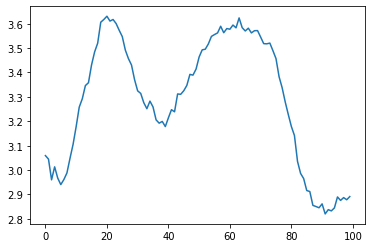

In [39]:
qc = HybridFunction.apply

def cost(x):
    target = -1
    expval = qc(x, circuit, SHIFT)
    return torch.abs(qc(x, circuit, SHIFT) - target) ** 2, expval

x = torch.tensor([[np.pi/4, np.pi/4, np.pi/4]], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))

So far, we have loaded the data and coded a class that creates our quantum circuit which contains 1 trainable parameter. This quantum parameter will be inserted into a classical neural network along with the other classical parameters to form the hybrid neural network. We also created backward and forward pass functions that allow us to do backpropagation and optimise our neural network. Lastly, we need to specify our neural network architecture such that we can begin to train our parameters using optimisation techniques provided by PyTorch. 


### 3.5 Creating the Hybrid Neural Network <a id='hybrid-nn'></a>
We can use a neat PyTorch pipeline to create a neural network architecture. The network will need to be compatible in terms of its dimensionality when we insert the quantum layer (i.e. our quantum circuit). Since our quantum  in this example contains 1 parameter, we must ensure the network condenses neurons down to size 1. We create a typical Convolutional Neural Network with two fully-connected layers at the end. The value of the last neuron of the fully-connected layer is fed as the parameter $\theta$ into our quantum circuit. The circuit measurement then serves as the final prediction for 0 or 1 as provided by a $\sigma_z$ measurement.

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 3)
        self.hybrid1 = Hybrid(2, qiskit.Aer.get_backend('qasm_simulator'), NUM_SHOTS, SHIFT)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid1(x)
        return torch.cat((x, 1 - x), -1)

### 3.6 Training the Network <a id='training'></a>
We now have all the ingredients to train our hybrid network! We can specify any [PyTorch optimiser](https://pytorch.org/docs/stable/optim.html), [learning rate](https://en.wikipedia.org/wiki/Learning_rate) and [cost/loss function](https://en.wikipedia.org/wiki/Loss_function) in order to train over multiple epochs. In this instance, we use the [Adam optimiser](https://arxiv.org/abs/1412.6980), a learning rate of 0.001 and the [negative log-likelihood loss function](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html).

In [41]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        print(output)
        print(target)
        # Calculating loss
        loss = loss_func(output, target)
        print(loss)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

tensor([[ 5.7201, -4.7201]], dtype=torch.float64, grad_fn=<CatBackward>)
tensor([2])


IndexError: Target 2 is out of bounds.

Plot the training graph

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

### 3.7 Testing the Network <a id='testing'></a>

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

In [ ]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

## 4. What Now? <a id='what-now'></a>

#### While it is totally possible to create hybrid neural networks, does this actually have any benefit? 

In fact, the classical layers of this network train perfectly fine (in fact, better) without the quantum layer. Furthermore, you may have noticed that the quantum layer we trained here **generates no entanglement**, and will, therefore, continue to be classically simulatable as we scale up this particular architecture. This means that if you hope to achieve a quantum advantage using hybrid neural networks, you'll need to start by extending this code to include a more sophisticated quantum layer. 


The point of this exercise was to get you thinking about integrating techniques from ML and quantum computing in order to investigate if there is indeed some element of interest - and thanks to PyTorch and Qiskit, this becomes a little bit easier. 

In [ ]:
import qiskit
qiskit.__qiskit_version__

## 